<a href="https://colab.research.google.com/github/GingerSpacetail/Binary-classification-ovarian-cancer-or-healthy-subject-SVM-GE-lab/blob/main/Binary_classification_ovarian_cancer_or_healthy_subject_SVM_GE_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# -=-=-=-=-=-=-=Support Vector Machines-=-=-=-=-=-=-

In [1]:
# Mounting your Google Drive to your Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  A) Binary Classification

### Supprt Vector Machines (SVM) are a powerful class of supervised classification and also regression. In this exercise, we will review the SVM practically and use it for classification problems.

In [2]:
# importing the libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns; sns.set()

### The purpose here is to define a line in 2D or a manifold in multi-dimensions to divide classes of the data. For instance, consider the following simple case of a 2D data set which are linearly separable.

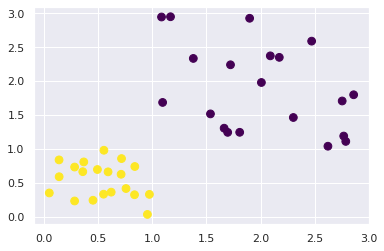

In [3]:
data = pd.read_csv('/content/drive/My Drive/Data/Data0.csv', header=None)
X = data.values[:, :2]
y = data.values[:, 2]
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap='viridis');

### In this simple example, there are two classes highlighted with different colors. The classes do not have overlap and therefore you can even use a linear equation to separate them from each other.. However, the problem is that there are unlimited number of such lines that are able to separate the classes. Based on which lines you choose,  a new data point will be either below or above the line and will be assigned to one of the classes. (The point marked by "X" in the following plot).

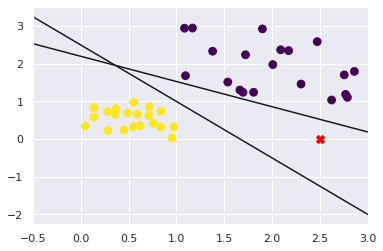

In [4]:
xfit = np.linspace(-0.5, 3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap='viridis')

# The following script draws a line by following the equation "Y-y0 = m(X-x0)" 
# on the data plane. Please note the valu inside each of the parentheses
# represent the parameters of 'm' and 'b' of the equation. 
for m, b in [(-0.67, 2.2), (-1.5,2.5)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.plot([2.5],[0],'X',color='red', markeredgewidth=1, markersize=8)

plt.xlim(-0.5, 3);

# TODO: Was the point "X" assigned to the same class when you used differen separating line?
# How do you justify such a discrepancy?

### It would be possible that the new data point was assigned to a different class based on the line you draw. One way to address such problems is to use two separating lines instead of only one line and maximize the distance between the two separating lines (maximize the margins). In fact, using only one line for separation is like to use two lines with a zero-width of margin. Therefore, we can add a margin between the separating lines and the line that maximizes this margin can be selected as an optimal line in SVM algorithm.

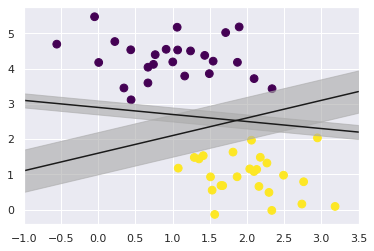

In [7]:
from sklearn.datasets import make_blobs  # Loading the input data
X, y = make_blobs(n_samples=50, centers=2,random_state=0, cluster_std=0.60)
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap='viridis')

# Comparing to the previous lines, here another parameter "d" is added.
# The parameter 'd' works as a bias to move the lines up and down.
# The following parameters of 'd' inside the parentheses are found experimentally.
# What SVM does, is finding the such parameters automatically.

for m, b, d in [ (0.5, 1.6, 0.6), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.6)

plt.xlim(-1, 3.5);

# TODO: Change the parameters 'd' inside the parentheses (0.6 and 0.2) and
# notice how it would change the margins. Please note the margins should not, optimally,
# include any data.

### Now, instead of finding the line and margin width manually, we are going to train a model by using a linear SVM to find the optimal parameters.

In [8]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)  # Set the linear kernel and a large value of C
model.fit(X, y) # Fitting the data set to the model

SVC(C=10000000000.0, kernel='linear')

### To understand what SVM does, it is better to visualize how it find the decision boundary.

In [9]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='r',
               levels=[-1, 0, 1], alpha=0.8,
               linestyles=['--', '-', '--'])
    
    # plot the support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=500, linewidth=10, facecolor='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

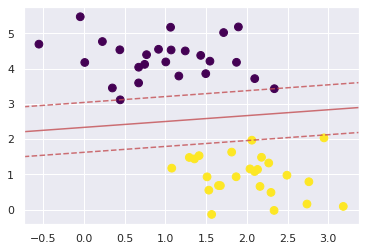

In [10]:
### Plotting the data point distributions:
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap='viridis')
# Drawing the decision boundaries.
plot_svc_decision_function(model);

### In the plot above, there is one solid line (main separating line) and two dashed-lines (margins). Any other lines will have less values of margin than the one above. Some of the training data points in this plot are placed exactly on the margin lines. In other words, margin lines passed through the middle of these points. These important points are called "Support Vectors" :

In [11]:
# Finding the exact number of Support Vectors.
n_support = model.support_vectors_
print('The number of support vector is: {}'.format(len(n_support)))

The number of support vector is: 3


### In SVMs, finding the optimum separating line  depends on the position (coordinates) of these Support Vectors. Other points further from the margins are in the correct sides and do not effect the fitting procedure. That is because these points do not contribute to the loss function used to fit the model, so their position and their frequency do not matter as long as they do not cross the margin. We can observe such behavior, for example, if we plot the model learned from the first 70 points and, then, first 140 points of this dataset:

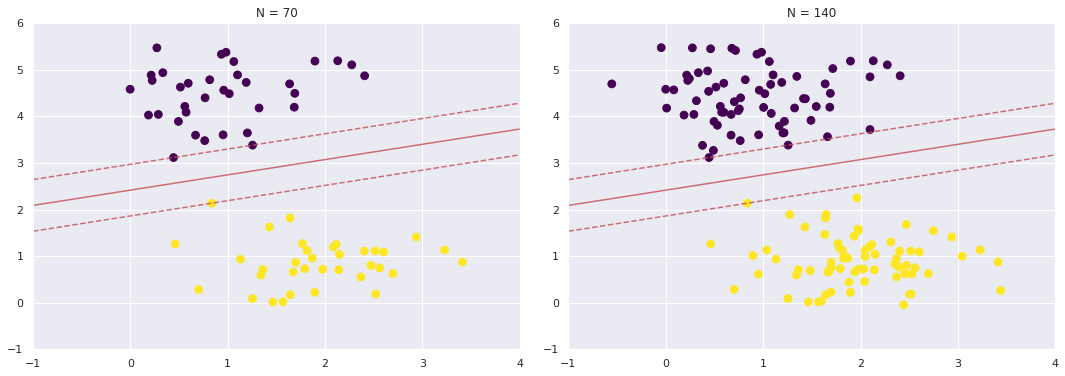

In [12]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap='viridis')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [70, 140]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

### The above two figures depict that SVM model fits the line using only Support Vectors and the model is not sensitive to other data points. In fact, the left figure contains half of the data points of the right figure, but both of them have the same separating lines because both of them have similar Support Vectors.

In [13]:
# Changing the number of the data points and interpret the results.
from ipywidgets import interact, fixed
interact(plot_svm, N=[8,10,20,50,100,150,180,300,500,2000], ax=fixed(None));

interactive(children=(Dropdown(description='N', index=1, options=(8, 10, 20, 50, 100, 150, 180, 300, 500, 2000…

### What about non-linear separable data set?

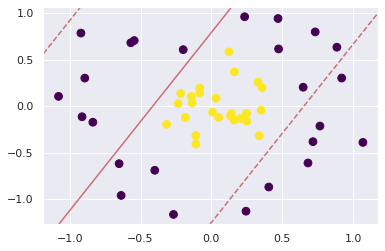

In [19]:
from sklearn.datasets import make_circles  # Load input data
X, y = make_circles(50, factor=.1, noise=0.2)

Model1 = SVC(kernel='linear').fit(X, y) # Fit a linear SVM

# Plot the data points distribution using the "plt.scatter"
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap='viridis')

# Call the function "plot_svc_decision_function" to draw the decision boundaries.
plot_svc_decision_function(Model1);

# TODO: Run this cell several times; are the drawn lines able to properly separate the classes?why?

### Could you observe acceptable results? Why?

### One practical way to handle nonlinear separable data set is to use "Kernel Trick". This means we can project our data set to a higher dimension space where the data points are linearly separable. There are different functions for this projection such as Gaussian (Radial) basis function and polynomials. In other words, we map a nonlinear separable data set into a higher dimension space, artificially, then within the new space linear separation would be sufficient.

In [20]:
# TODO: Run and play with the angles
# If you want separate the two classes in higher dimenstion linearly, which line will you use?
r = np.exp(-(X ** 2).sum(1))
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=60, cmap='viridis')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90,-60,0,30,90], azip=(-180,180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', index=3, options=(-90, -60, 0, 30, 90), value=30), IntSlide…

### Training a Kernel-based SVM

In [21]:
Model2 = SVC(kernel='rbf', C=1E6) # Creating an SVM with Radial Basis Function
Model2.fit(X, y)

SVC(C=1000000.0)

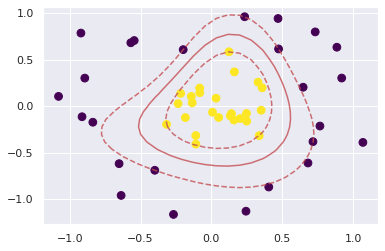

In [22]:
# Plotting the data points distribution using the "plt.scatter"
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap='viridis')

# Call the function "plot_svc_decision_function" to draw the decision boundaries.
plot_svc_decision_function(Model2)

### Soft Margin SVMs: So far we have seen data set with a clear decision boundary; however, in real cases data points from different classes often overlapping each other:

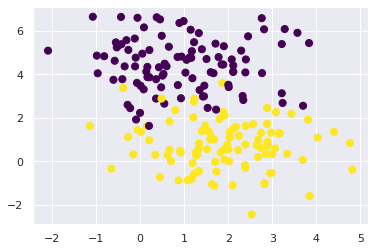

In [23]:
# Example of dataset with class overlapping
X, y = make_blobs(n_samples=200, centers=2,random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis');
# TODO: Is it possible to use linear or even kernel based SVM to classify these data?

### In previous examples there were a parameter "C" which we set it as a very large number. The role of this parameter is to prevent the data points from appearing inside the margins. The larger this value the lower the chance of data points inside the margins. Accordingly, if we do not allow any points to appear inside the margins we have a "Hard Margin SVM" like what we did in previous examples. On the other hand, we can allow the margins to be softer to contain some of the data points.

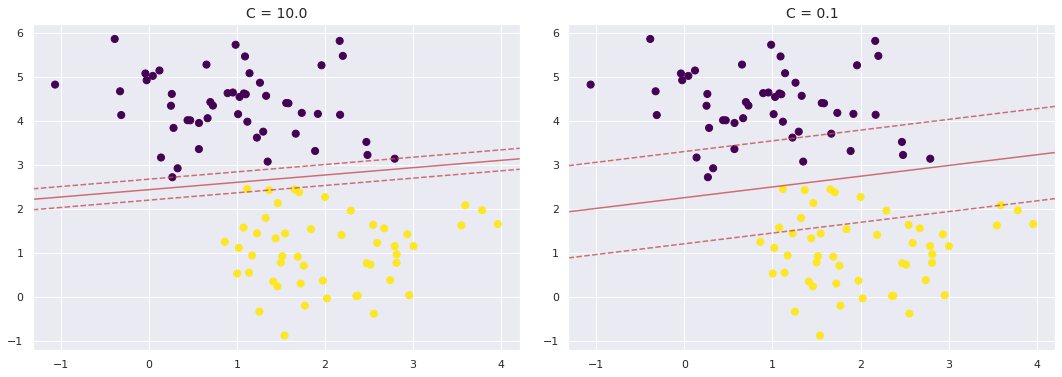

In [24]:
# Comparison of soft and hard margin SVM.
X, y = make_blobs(n_samples=100, centers=2,random_state=0, cluster_std=0.8) # Input Data

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)
    
# TODO: How do you compare these two figures?

## B) Multi-Class Classification Problem Examples:

### The idea is to train an SVM classifier using Iris data set with different Kernels. Iris data set contains 4 features for each data point including Sepal length, Sepal width, Petal length and Petal width all in cm. The target class of these data are Setosa, Versicolor, Virginica. Therefore, it is a 3 class classification problem where each data point is described with 4 features.

In [25]:
from sklearn import datasets # To Get iris dataset
from sklearn import svm    # To fit the svm classifier
iris_dataset = datasets.load_iris()
print ("Iris data set Description = ", iris_dataset['DESCR'])
print ("Iris targets = ", iris_dataset['target'])

Iris data set Description =  .. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== =

### We can visualize different features with the corresponding targets. For instance, visualizing Sepal length & width and the corresponding class labels.

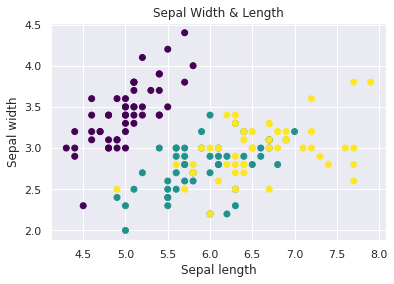

In [26]:
def visuvalize_sepal_data():
    iris = datasets.load_iris()
    X = iris.data[:, :2]  # we only take the first two features.
    y = iris.target
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.title('Sepal Width & Length')
    plt.show()
visuvalize_sepal_data()

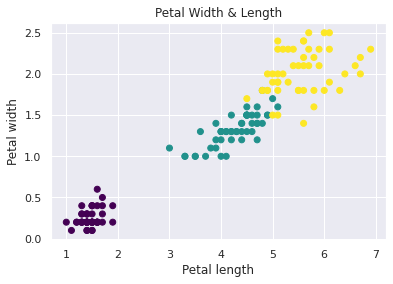

In [27]:
# Repeat the previous cells but for the last two features. (Petal length and width)
def visuvalize_petal_data():
    iris = datasets.load_iris()
    X = iris.data[:, 2:]  # we only take the last two features.
    y = iris.target
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.title('Petal Width & Length')
    plt.show()
 
visuvalize_petal_data()

### Modelling different kernel SVM by using only the Sepal features (Length and Width) and the Petal features (Lenght and Width) separately.

In [28]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the Sepal two features.
y = iris.target
C = 1  # SVM regularization parameter
 
# SVM with linear kernel
svc = svm.SVC(kernel='linear', C=C).fit(X, y)

# the same with "rbf" kernel
rbf_svc = svm.SVC(kernel='rbf', gamma=0.5, C=C).fit(X, y)


# the same with "poly" kernel (polynomial)
poly_svc = svm.SVC(kernel='poly', degree=4, C=C).fit(X, y)

###  In order to understand how well the SVM models classified the data, we can visualize it.

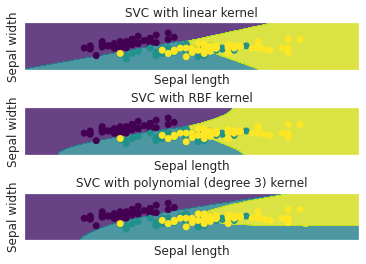

In [29]:
# Reading
# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
	                     np.arange(y_min, y_max, h))
# title for the plots
titles = ['SVC with linear kernel',
	    'SVC with RBF kernel',
	    'SVC with polynomial (degree 3) kernel']
 
 
for i, clf in enumerate((svc, rbf_svc, poly_svc)):
	 # Plot the decision boundary. For that, we will assign a color to each
	 # point in the mesh [x_min, x_max]x[y_min, y_max].
	 plt.subplot(3, 1, i + 1)
	 plt.subplots_adjust(wspace=0.4, hspace=0.8)
 
	 Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
 
	 # Put the result into a color plot
	 Z = Z.reshape(xx.shape)
	 plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.8)
 
	 # Plot also the training points
	 plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
	 plt.xlabel('Sepal length')
	 plt.ylabel('Sepal width')
	 plt.xlim(xx.min(), xx.max())
	 plt.ylim(yy.min(), yy.max())
	 plt.xticks(())
	 plt.yticks(())
	 plt.title(titles[i])
 
plt.show()

In [ ]:
# TODO: Change the parameters C, standard deviation of RBF kernels (gammas) and polynomial order (degree)
# and find out how they effect the output. 

### The same process for Iris Petal features

In [30]:
X = iris.data[:, 2:]  # we only take the last two features.
y = iris.target
C = 1.0  # SVM regularization parameter
 
# SVC with linear kernel
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
# SVC with RBF kernel
rbf_svc = svm.SVC(kernel='rbf', gamma=0.5, C=C).fit(X, y)
# SVC with polynomial (degree 3) kernel
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)

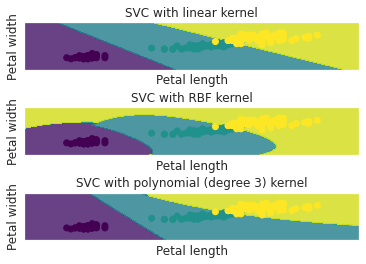

In [31]:
h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
	            np.arange(y_min, y_max, h))
# title for the plots
titles = ['SVC with linear kernel',
	  'SVC with RBF kernel',
	  'SVC with polynomial (degree 3) kernel']
 
 
for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(3, 1, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
 
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.8)
 
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
 
plt.show()

# C) Train and Test with SVM

### We are going to use a real clinical data set (Data1.csv). This data set contain 216 subjects each of which presented with 100 quantified values (clinical Proteomics). Out of all the subjects, 121 are diagnosed as ovarian cancer and 95 are healthy subjects. Therefore, it is binary classification and the class labels are set as -1 and +1.

In [32]:
# Read
from sklearn.svm import SVC
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/drive/My Drive/Data/Data1.csv', header=None) # Input data

### The purpose is to divide the data set into train and test set, using the training data to learn the model and evaluate the performance of the learned model on the unseen, test, data.

In [33]:
# Set the first 100 columns as input data
X = data.values[:, :100]

# Set the last column as targets
y = data.values[:, 100]

# spliting the data into train and test sets randomly.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [34]:
# Train a SVM with training data
C = 1
Model4 = SVC(kernel='linear', C=C) 
Model4.fit(X_train,y_train) 

# Predicting the label of the unseen data
y_pred = Model4.predict(X_test) 

print('Prediction Accuracy Score is:',metrics.accuracy_score(y_test,y_pred))

Prediction Accuracy Score is: 0.9090909090909091


In [35]:
# Repeating the previous cell for 'rbf' kernel
Model5 = SVC(kernel='rbf',gamma=0.1, C=C)
Model5.fit(X_train,y_train)
y_pred = Model5.predict(X_test)
print('Prediction Accuracy Score is:',metrics.accuracy_score(y_test,y_pred))

Prediction Accuracy Score is: 0.9772727272727273


In [36]:
#TODO: Repeat the whole previous cell for 'poly' kernel
Model6 = SVC(kernel='poly',degree=2, C=C)
Model6.fit(X_train,y_train)
y_pred = Model6.predict(X_test)
print('Prediction Accuracy Score is:',metrics.accuracy_score(y_test,y_pred))

Prediction Accuracy Score is: 0.9772727272727273


In [37]:
# Performing K-fold (k=5) cross validation with Linear kernel
from sklearn.model_selection import cross_val_score
Model7 = SVC(kernel='linear')
# TODO: play with the parameter cv and find out how it works.
scores = cross_val_score(Model7, X, y, cv=5, scoring='accuracy') #cv is cross validation
print(scores)

# TODO: How cross validation would help the classification task?
# TODO: Can you explain the achieved scores in terms of bias-variance matter?

[0.86363636 0.97674419 0.93023256 0.93023256 1.        ]


### As an another basic example, we are going to classify MR breast images from MR bladder images. The images were rescaled to 40*40 pixels and the pixel values were used as the data. Therefore, each subject is presented by a vector with length of 1600 values. 

In [38]:
# Reading the input data: "RawPixels.csv"
data = pd.read_csv('/content/drive/My Drive/Data/RawPixels.csv', header=None)
X = data.values[:, :1600] # input data
y = data.values[:, 1600] # targets

# Splitting the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


C = 1
Model9 = SVC(kernel='linear', C=C)
Model9.fit(X_train,y_train)

y_pred = Model9.predict(X_test) 
print('The Accuracy Score is:',metrics.accuracy_score(y_test,y_pred))

The Accuracy Score is: 1.0


#####